In [17]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

batch_size = 32


transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('./drive/MyDrive/oxford-iiit-pet/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(nfeats * 8)
        
        self.conv2 = nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 8)
        
        self.conv3 = nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        
        self.conv4 = nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 2)
        
        self.conv5 = nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(nfeats)
        
        self.conv6 = nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False)


    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = torch.tanh(self.conv6(x))
        
        return x


class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        
        self.conv2 = nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        
        self.conv3 = nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
       
        self.conv4 = nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 8)
        
        self.conv5 = nn.Conv2d(nfeats * 8, 1, 4, 1, 0, bias=False)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        
        return x.view(-1, 1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0003
beta1 = 0.5

netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.9
fake_label = 0
batch_size = train_loader.batch_size




epochs = 2

step = 0
for epoch in range(epochs):
    for ii, (real_images, train_labels) in enumerate(train_loader):
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        labels.fill_(real_label)  
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if step % 500 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        



if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

[1/2][0/77] Loss_D: 1.2836 Loss_G: 3.8754 D(x): 0.5348 D(G(z)): 0.4642 / 0.0137


'/content/images.zip'

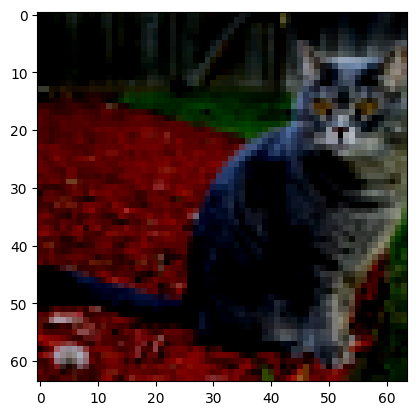

In [30]:
plt.imshow(images[10])